# Importanción de librerías 

In [1]:
import tensorflow as tf
import sklearn
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import librosa
import os

In [2]:
tf.test.is_gpu_available()

True

# Generación de ficheros

Esta función se encarga de generar un archivo txt de manera que este contenga 2 elementos por fila ('name_file','etiqueta') de esta manera permitirá poder entrenar la red.

In [3]:
import numpy as np
import os
def generate_file_data(dir,name):
    directory=dir
    #el nombre de los archivos posee el primer dígito en el nombre de esta forma permitirá etiquetarlos.
    a={'0':'cero','1':'uno','2':'dos','3':'tres','4':'cuatro','5':'cinco','6':'seis','7':'siete','8':'ocho','9':'nueve'}
    da=os.listdir(directory)
    # ordena los archivos
    da.sort()
    file = open(dir+name+'.txt',"w")
    for filename in da:
        if '.wav' in filename:
            file.write(filename+','+a[filename[0]]+'\n')
    file.close() 
    # genera el fichero
    with open(directory+'/'+name+'.txt') as f:
        read_data = f.read()
        f.closed
    read_data=read_data.split('\n')
    read_data=read_data[0:len(read_data)-1]
    return read_data

# Encoding words with One Hot Encoding
En esta sección se usará one hot encoding para representar las palabras

In [10]:
from sklearn.preprocessing import OneHotEncoder
import sklearn.externals.joblib as joblib
vocabulary_words=np.array(['cero','uno','dos','tres','cuatro','cinco','seis','siete','ocho','nueve'])

In [11]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore',categories='auto')

In [12]:
onehot_encoder.fit(X=vocabulary_words.reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [13]:
joblib.dump(onehot_encoder,'OneHotEncoding/onehot')

['OneHotEncoding/onehot']

In [14]:
#onehot_encoder=joblib('OneHotEncoding/onehot')

In [15]:
onehot_encoder.categories_

[array(['cero', 'cinco', 'cuatro', 'dos', 'nueve', 'ocho', 'seis', 'siete',
        'tres', 'uno'], dtype='<U6')]

In [16]:
v=onehot_encoder.transform(vocabulary_words.reshape(-1,1)).toarray()

In [17]:
v

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [18]:
onehot_encoder.inverse_transform(v)

array([['cero'],
       ['uno'],
       ['dos'],
       ['tres'],
       ['cuatro'],
       ['cinco'],
       ['seis'],
       ['siete'],
       ['ocho'],
       ['nueve']], dtype='<U6')

### Se muestran las funciones para codificar y decodificar

In [19]:
def encode(x):# tomará un array de string y lo transformada a encode
    return onehot_encoder.transform(x.reshape(-1,1)).toarray()
def decode(x):
    return onehot_encoder.inverse_transform(x)

In [13]:
a=encode(np.array(['uno','dos']))

In [14]:
a

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [15]:
decode(a)

array([['uno'],
       ['dos']], dtype='<U6')

# MFCC 


In [20]:
def mfcc_features(DIR,list_dir):
    mfcc_audios=[]
    for dir in list_dir:
        wave, sr = librosa.load(DIR+dir, mono=True)
        features= librosa.feature.mfcc(wave, sr,n_mfcc=13)
        try:
            features=np.pad(features,((0,0),(0,150-len(features[0]))),mode='constant', constant_values=0)
        except OSError as err:
            print(dir)
        mfcc_audios.append(features)
    mfcc_audios=np.array(mfcc_audios)
    return mfcc_audios

In [21]:
def prepare_data(dir,name):
    file = open(dir+name)
    f=file.read()
    file.close()
    f=f.split('\n')
    f=f[0:len(f)-1]
    labels=[]
    names_audios=[]
    for i in f:
        j=i.split(',')
        names_audios.append(j[0])
        labels.append(j[1])
    labels=np.array(labels)
    onehot= encode(labels)
    mfcc=mfcc_features(dir,names_audios)
    print(name+' OK')
    return mfcc,onehot



In [22]:
class dataset:
    def __init__(self,data):
        self.i=0#para el shuffle
        self.data_dir=data
        self.shuffle=None
        self.dir_training=data+'/training/'
        self.dir_test=data+'/test/'
        self.training_set=None
        self.test_set=None
    def split_dataset(self):
        if os.path.exists(self.dir_training+'training.txt')==False:
            generate_file_data(self.dir_training,name='training')
        if os.path.exists(self.dir_training+'test.txt')==False:
            generate_file_data(self.dir_test,name='test')
        print('loadfiles')
    def prepare(self):
        self.training_set=prepare_data(self.dir_training,'training.txt')
        self.test_set=prepare_data(self.dir_test,'test.txt')

    

In [24]:
d=dataset('data')
d.split_dataset()

loadfiles


In [25]:
d.prepare()

training.txt OK
test.txt OK


# Red neuronal 

En esta sección se definen los distintos modelos a aplicar en este seminario

In [23]:
import sklearn
import tensorflow as tf
import time 
import matplotlib.pyplot as plt
import json
import os

In [26]:
# Se dividen los conjuntos
trainX, trainY = d.training_set[0],d.training_set[1]
testX, testY = d.test_set[0],d.test_set[1]
trainX=np.matrix.transpose(trainX,[0,2,1])
testX=np.matrix.transpose(testX,[0,2,1])

##### A continuación mostramos un elemento del training y test

In [27]:
trainX[0]

array([[-5.64680866e+02,  1.31315456e+00,  9.67559702e-01, ...,
         9.03508161e-02,  2.96625196e-01,  4.66707148e-01],
       [-5.29639572e+02,  3.83504027e+01,  1.58076723e+01, ...,
        -5.14833455e+00, -1.47919159e+00,  7.28436449e+00],
       [-5.03711243e+02,  5.91761157e+01,  1.61406856e+01, ...,
        -7.01928874e+00, -5.68180924e+00,  7.32273427e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [28]:
trainX.shape

(240, 150, 13)

## Modelos de prueba
A continuación presentamos 4 modelos que serán entrenados para el reconocimiento de voz.

In [24]:
def RNN_simple(name,n_units=128,time_steps=150,n_inputs=13,batch_size=10,n_epochs=400):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.SimpleRNN(128, input_shape=(time_steps,n_inputs)))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

In [25]:
def LSTM_simple(name,n_units=128,time_steps=150,n_inputs=13,batch_size=10,n_epochs=400):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs)))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

In [26]:
def LSTM_with_Dropout(name,n_units=128,time_steps=150,n_inputs=13,batch_size=10,n_epochs=400,dropout=0.5):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs)))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

In [34]:
def LSTM_with_2layers(name,n_units=64,time_steps=150,n_inputs=13,batch_size=10,n_epochs=400):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs),return_sequences=True))
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs)))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

In [30]:
def LSTM_with_2layers_2D(name,dropout,n_units=64,time_steps=150,n_inputs=13,batch_size=10,n_epochs=400):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs),return_sequences=True))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs)))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

## Plotting and saving modelo
Se presentará una función que graficará los resultados y guardará el modelo y sus datos de entrenamiento

In [32]:
def plot_and_saving(history,name):
    dir='Models/Model_'
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Precision del Modelo')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Test'], loc='upper left')
    plt.savefig(dir+name+'/prec')
    plt.show()
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Perdida del modelo')
    plt.ylabel('Perdida')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Test'], loc='upper left')
    plt.savefig(dir+name+'/cost')
    plt.show()
    json.dump(history.history, open('Models/Model_'+name+'/'+name+'_history', 'w'))


# Entrenamientos
Entrenaremos distintas con los modelos definidos y luego se propondrá un modelo que reduzca los problemas de los otros.

## Pruebas

In [46]:
#RNN=RNN_simple('RNNsimple13mfcc',n_units=64)

Train on 240 samples, validate on 110 samples
Epoch 1/400
240/240 [==============================] - 2s 10ms/step - loss: 2.3608 - acc: 0.1167 - val_loss: 2.3434 - val_acc: 0.1091
Epoch 2/400
240/240 [==============================] - 2s 6ms/step - loss: 2.3396 - acc: 0.0917 - val_loss: 2.3480 - val_acc: 0.1273
Epoch 3/400
240/240 [==============================] - 2s 8ms/step - loss: 2.3537 - acc: 0.1125 - val_loss: 2.3155 - val_acc: 0.1364
Epoch 4/400
240/240 [==============================] - 2s 8ms/step - loss: 2.3533 - acc: 0.1000 - val_loss: 2.3636 - val_acc: 0.1000
Epoch 5/400
240/240 [==============================] - 2s 7ms/step - loss: 2.3236 - acc: 0.0958 - val_loss: 2.3196 - val_acc: 0.1182
Epoch 6/400
240/240 [==============================] - 2s 8ms/step - loss: 2.2885 - acc: 0.1625 - val_loss: 2.4294 - val_acc: 0.0818
Epoch 7/400
240/240 [==============================] - 2s 8ms/step - loss: 2.3391 - acc: 0.1250 - val_loss: 2.3935 - val_acc: 0.0636
Epoch 8/400
240/240 [=

Epoch 62/400
240/240 [==============================] - 2s 6ms/step - loss: 2.2636 - acc: 0.1583 - val_loss: 2.3976 - val_acc: 0.0636
Epoch 63/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2542 - acc: 0.1750 - val_loss: 2.4040 - val_acc: 0.0909
Epoch 64/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2490 - acc: 0.1625 - val_loss: 2.3880 - val_acc: 0.0727
Epoch 65/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2478 - acc: 0.1583 - val_loss: 2.4143 - val_acc: 0.0727
Epoch 66/400
240/240 [==============================] - 2s 6ms/step - loss: 2.2514 - acc: 0.1708 - val_loss: 2.4165 - val_acc: 0.0545
Epoch 67/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2519 - acc: 0.1792 - val_loss: 2.4091 - val_acc: 0.0455
Epoch 68/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2589 - acc: 0.1500 - val_loss: 2.4070 - val_acc: 0.0545
Epoch 69/400
240/240 [==============================] - 1s 5ms

Epoch 123/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2624 - acc: 0.1708 - val_loss: 2.4238 - val_acc: 0.1091
Epoch 124/400
240/240 [==============================] - 2s 6ms/step - loss: 2.2496 - acc: 0.1667 - val_loss: 2.3987 - val_acc: 0.1000
Epoch 125/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2612 - acc: 0.1917 - val_loss: 2.4176 - val_acc: 0.0636
Epoch 126/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2514 - acc: 0.1833 - val_loss: 2.3914 - val_acc: 0.0636
Epoch 127/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2582 - acc: 0.1750 - val_loss: 2.3978 - val_acc: 0.1273
Epoch 128/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2504 - acc: 0.1667 - val_loss: 2.3984 - val_acc: 0.0727
Epoch 129/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2524 - acc: 0.1792 - val_loss: 2.4041 - val_acc: 0.0727
Epoch 130/400
240/240 [==============================] 

Epoch 244/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2506 - acc: 0.1667 - val_loss: 2.4256 - val_acc: 0.1000
Epoch 245/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2407 - acc: 0.1875 - val_loss: 2.4124 - val_acc: 0.1091
Epoch 246/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2343 - acc: 0.1917 - val_loss: 2.4116 - val_acc: 0.0909
Epoch 247/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2428 - acc: 0.1792 - val_loss: 2.4303 - val_acc: 0.0818
Epoch 248/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2545 - acc: 0.1750 - val_loss: 2.4248 - val_acc: 0.0909
Epoch 249/400
240/240 [==============================] - 1s 6ms/step - loss: 2.3684 - acc: 0.1042 - val_loss: 2.3909 - val_acc: 0.0818
Epoch 250/400
240/240 [==============================] - 2s 6ms/step - loss: 2.3158 - acc: 0.1500 - val_loss: 2.3915 - val_acc: 0.1000
Epoch 251/400
240/240 [==============================] 

Epoch 365/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2504 - acc: 0.1625 - val_loss: 2.3854 - val_acc: 0.1091
Epoch 366/400
240/240 [==============================] - 2s 8ms/step - loss: 2.2462 - acc: 0.1792 - val_loss: 2.3946 - val_acc: 0.0818
Epoch 367/400
240/240 [==============================] - 2s 9ms/step - loss: 2.2415 - acc: 0.1583 - val_loss: 2.3718 - val_acc: 0.1000
Epoch 368/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2450 - acc: 0.1542 - val_loss: 2.3765 - val_acc: 0.1182
Epoch 369/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2453 - acc: 0.1792 - val_loss: 2.3884 - val_acc: 0.0727
Epoch 370/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2478 - acc: 0.1833 - val_loss: 2.3849 - val_acc: 0.1091
Epoch 371/400
240/240 [==============================] - 2s 9ms/step - loss: 2.2408 - acc: 0.1583 - val_loss: 2.3722 - val_acc: 0.1182
Epoch 372/400
240/240 [==============================] 

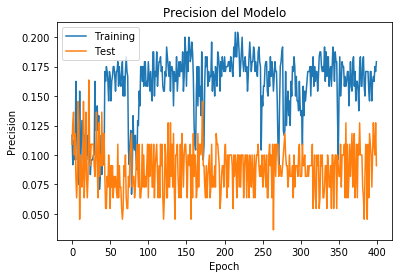

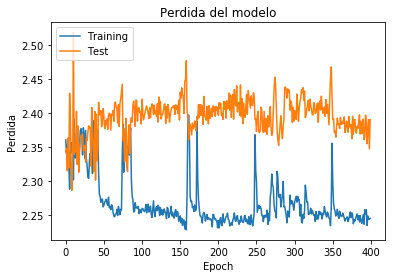

In [47]:
#plot_and_saving(RNN,'RNNsimple13mfcc')

In [33]:
#LSTM=LSTM_simple(name="LSTMSIMPLE",n_epochs=550,n_units=64)

Train on 240 samples, validate on 110 samples
Epoch 1/550
240/240 [==============================] - 7s 31ms/step - loss: 2.3072 - acc: 0.0750 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/550
240/240 [==============================] - 4s 18ms/step - loss: 2.3009 - acc: 0.0958 - val_loss: 2.3021 - val_acc: 0.0909
Epoch 3/550
240/240 [==============================] - 7s 27ms/step - loss: 2.2899 - acc: 0.1000 - val_loss: 2.3128 - val_acc: 0.1000
Epoch 4/550
240/240 [==============================] - 6s 27ms/step - loss: 2.2856 - acc: 0.1208 - val_loss: 2.2979 - val_acc: 0.1091
Epoch 5/550
240/240 [==============================] - 6s 26ms/step - loss: 2.2770 - acc: 0.1125 - val_loss: 2.2964 - val_acc: 0.1182
Epoch 6/550
240/240 [==============================] - 4s 16ms/step - loss: 2.2752 - acc: 0.1083 - val_loss: 2.3053 - val_acc: 0.1000
Epoch 7/550
240/240 [==============================] - 4s 15ms/step - loss: 2.2715 - acc: 0.1042 - val_loss: 2.2996 - val_acc: 0.1091
Epoch 8/550
240/

240/240 [==============================] - 4s 16ms/step - loss: 0.8761 - acc: 0.6417 - val_loss: 2.0832 - val_acc: 0.3273
Epoch 122/550
240/240 [==============================] - 4s 15ms/step - loss: 0.8839 - acc: 0.6125 - val_loss: 2.3291 - val_acc: 0.2636
Epoch 123/550
240/240 [==============================] - 4s 16ms/step - loss: 0.9888 - acc: 0.5667 - val_loss: 2.2978 - val_acc: 0.3000
Epoch 124/550
240/240 [==============================] - 4s 15ms/step - loss: 1.0492 - acc: 0.5750 - val_loss: 2.0468 - val_acc: 0.3545
Epoch 125/550
240/240 [==============================] - 4s 15ms/step - loss: 1.5684 - acc: 0.4208 - val_loss: 2.5548 - val_acc: 0.2364
Epoch 126/550
240/240 [==============================] - 4s 15ms/step - loss: 1.7458 - acc: 0.3333 - val_loss: 2.3668 - val_acc: 0.3000
Epoch 127/550
240/240 [==============================] - 4s 15ms/step - loss: 1.5894 - acc: 0.3708 - val_loss: 2.0627 - val_acc: 0.3364
Epoch 128/550
240/240 [==============================] - 4s 15

240/240 [==============================] - 4s 15ms/step - loss: 0.5579 - acc: 0.7958 - val_loss: 2.3905 - val_acc: 0.3727
Epoch 242/550
240/240 [==============================] - 4s 15ms/step - loss: 0.6052 - acc: 0.7958 - val_loss: 2.4878 - val_acc: 0.3455
Epoch 243/550
240/240 [==============================] - 4s 15ms/step - loss: 0.5430 - acc: 0.8333 - val_loss: 2.5040 - val_acc: 0.3273
Epoch 244/550
240/240 [==============================] - 4s 16ms/step - loss: 0.4754 - acc: 0.8292 - val_loss: 2.5570 - val_acc: 0.3455
Epoch 245/550
240/240 [==============================] - 4s 15ms/step - loss: 0.3998 - acc: 0.8708 - val_loss: 2.4806 - val_acc: 0.3455
Epoch 246/550
240/240 [==============================] - 4s 15ms/step - loss: 0.3665 - acc: 0.8833 - val_loss: 2.5749 - val_acc: 0.3273
Epoch 247/550
240/240 [==============================] - 4s 15ms/step - loss: 0.3564 - acc: 0.9042 - val_loss: 2.5136 - val_acc: 0.3636
Epoch 248/550
240/240 [==============================] - 4s 15

240/240 [==============================] - 4s 15ms/step - loss: 0.0603 - acc: 0.9917 - val_loss: 2.7938 - val_acc: 0.4273
Epoch 362/550
240/240 [==============================] - 4s 15ms/step - loss: 0.0663 - acc: 0.9875 - val_loss: 2.7522 - val_acc: 0.4455
Epoch 363/550
240/240 [==============================] - 4s 15ms/step - loss: 0.0464 - acc: 0.9958 - val_loss: 2.7925 - val_acc: 0.4364
Epoch 364/550
240/240 [==============================] - 4s 15ms/step - loss: 0.0469 - acc: 0.9958 - val_loss: 2.8160 - val_acc: 0.4455
Epoch 365/550
240/240 [==============================] - 4s 16ms/step - loss: 0.0473 - acc: 0.9917 - val_loss: 2.8863 - val_acc: 0.4455
Epoch 366/550
240/240 [==============================] - 4s 15ms/step - loss: 0.0416 - acc: 0.9917 - val_loss: 2.9024 - val_acc: 0.4455
Epoch 367/550
240/240 [==============================] - 4s 15ms/step - loss: 0.0394 - acc: 0.9917 - val_loss: 2.9116 - val_acc: 0.4455
Epoch 368/550
240/240 [==============================] - 4s 18

240/240 [==============================] - 4s 16ms/step - loss: 0.2610 - acc: 0.9292 - val_loss: 2.2432 - val_acc: 0.4727
Epoch 482/550
240/240 [==============================] - 4s 18ms/step - loss: 0.2353 - acc: 0.9375 - val_loss: 2.2341 - val_acc: 0.4636
Epoch 483/550
240/240 [==============================] - 5s 20ms/step - loss: 0.2201 - acc: 0.9333 - val_loss: 2.2557 - val_acc: 0.4818
Epoch 484/550
240/240 [==============================] - 4s 19ms/step - loss: 0.2250 - acc: 0.9333 - val_loss: 2.3114 - val_acc: 0.4636
Epoch 485/550
240/240 [==============================] - 5s 19ms/step - loss: 0.2196 - acc: 0.9208 - val_loss: 2.4147 - val_acc: 0.4545
Epoch 486/550
240/240 [==============================] - 4s 17ms/step - loss: 0.1996 - acc: 0.9375 - val_loss: 2.4389 - val_acc: 0.4818
Epoch 487/550
240/240 [==============================] - 5s 21ms/step - loss: 0.1869 - acc: 0.9458 - val_loss: 2.4064 - val_acc: 0.5091
Epoch 488/550
240/240 [==============================] - 5s 22

In [34]:
#LSTM_DF64=LSTM_with_Dropout(name='LSTM_dropmfcc64',n_units=64,n_epochs=800,dropout=0.6)

Train on 240 samples, validate on 110 samples
Epoch 1/800
240/240 [==============================] - 5s 19ms/step - loss: 2.3048 - acc: 0.0750 - val_loss: 2.3026 - val_acc: 0.0909
Epoch 2/800
240/240 [==============================] - 4s 15ms/step - loss: 2.3001 - acc: 0.0958 - val_loss: 2.3025 - val_acc: 0.1000
Epoch 3/800
240/240 [==============================] - 4s 15ms/step - loss: 2.2977 - acc: 0.0875 - val_loss: 2.3024 - val_acc: 0.1091
Epoch 4/800
240/240 [==============================] - 4s 15ms/step - loss: 2.2901 - acc: 0.1000 - val_loss: 2.3037 - val_acc: 0.1000
Epoch 5/800
240/240 [==============================] - 4s 15ms/step - loss: 2.2848 - acc: 0.0958 - val_loss: 2.3008 - val_acc: 0.1000
Epoch 6/800
240/240 [==============================] - 4s 15ms/step - loss: 2.2747 - acc: 0.0750 - val_loss: 2.3081 - val_acc: 0.1364
Epoch 7/800
240/240 [==============================] - 4s 15ms/step - loss: 2.2759 - acc: 0.0917 - val_loss: 2.3071 - val_acc: 0.1091
Epoch 8/800
240/

240/240 [==============================] - 4s 17ms/step - loss: 0.7692 - acc: 0.7708 - val_loss: 1.8659 - val_acc: 0.4545
Epoch 122/800
240/240 [==============================] - 4s 17ms/step - loss: 0.7919 - acc: 0.7250 - val_loss: 1.8509 - val_acc: 0.4636
Epoch 123/800
240/240 [==============================] - 4s 16ms/step - loss: 0.7127 - acc: 0.8042 - val_loss: 1.9489 - val_acc: 0.4364
Epoch 124/800
240/240 [==============================] - 4s 18ms/step - loss: 1.0851 - acc: 0.6167 - val_loss: 2.0230 - val_acc: 0.3182
Epoch 125/800
240/240 [==============================] - 4s 17ms/step - loss: 1.2531 - acc: 0.5583 - val_loss: 1.6619 - val_acc: 0.4818
Epoch 126/800
240/240 [==============================] - 4s 17ms/step - loss: 1.1722 - acc: 0.5667 - val_loss: 1.6568 - val_acc: 0.4545
Epoch 127/800
240/240 [==============================] - 4s 16ms/step - loss: 0.9645 - acc: 0.6667 - val_loss: 1.7531 - val_acc: 0.4273
Epoch 128/800
240/240 [==============================] - 4s 19

240/240 [==============================] - 4s 15ms/step - loss: 0.6059 - acc: 0.8083 - val_loss: 2.1925 - val_acc: 0.4000
Epoch 242/800
240/240 [==============================] - 4s 15ms/step - loss: 0.5254 - acc: 0.8167 - val_loss: 2.0924 - val_acc: 0.4273
Epoch 243/800
240/240 [==============================] - 4s 15ms/step - loss: 0.4472 - acc: 0.8458 - val_loss: 2.1764 - val_acc: 0.4000
Epoch 244/800
240/240 [==============================] - 4s 15ms/step - loss: 0.4312 - acc: 0.8542 - val_loss: 2.1634 - val_acc: 0.4182
Epoch 245/800
240/240 [==============================] - 4s 15ms/step - loss: 0.3820 - acc: 0.8708 - val_loss: 2.2534 - val_acc: 0.4091
Epoch 246/800
240/240 [==============================] - 4s 15ms/step - loss: 0.3487 - acc: 0.9042 - val_loss: 2.2445 - val_acc: 0.4000
Epoch 247/800
240/240 [==============================] - 4s 15ms/step - loss: 0.3036 - acc: 0.9125 - val_loss: 2.2740 - val_acc: 0.4273
Epoch 248/800
240/240 [==============================] - 4s 15

KeyboardInterrupt: 

In [74]:
#LSTM_DF128=LSTM_with_Dropout(name='LSTM_dropmfcc128',n_units=128,n_epochs=800,dropout=0.8)

Train on 240 samples, validate on 110 samples
Epoch 1/800
240/240 [==============================] - 6s 27ms/step - loss: 2.3047 - acc: 0.0708 - val_loss: 2.3025 - val_acc: 0.1000
Epoch 2/800
240/240 [==============================] - 4s 17ms/step - loss: 2.2964 - acc: 0.0917 - val_loss: 2.2999 - val_acc: 0.1091
Epoch 3/800
240/240 [==============================] - 4s 17ms/step - loss: 2.2915 - acc: 0.0958 - val_loss: 2.3074 - val_acc: 0.1091
Epoch 4/800
240/240 [==============================] - 4s 17ms/step - loss: 2.2751 - acc: 0.1167 - val_loss: 2.3029 - val_acc: 0.0909
Epoch 5/800
240/240 [==============================] - 4s 17ms/step - loss: 2.2708 - acc: 0.1208 - val_loss: 2.2897 - val_acc: 0.0909
Epoch 6/800
240/240 [==============================] - 4s 17ms/step - loss: 2.2700 - acc: 0.1167 - val_loss: 2.3051 - val_acc: 0.1000
Epoch 7/800
240/240 [==============================] - 4s 17ms/step - loss: 2.2822 - acc: 0.1125 - val_loss: 2.3057 - val_acc: 0.1000
Epoch 8/800
240/

240/240 [==============================] - 4s 17ms/step - loss: 1.5607 - acc: 0.3125 - val_loss: 1.7573 - val_acc: 0.2909
Epoch 122/800
240/240 [==============================] - 4s 17ms/step - loss: 1.3648 - acc: 0.3583 - val_loss: 1.6395 - val_acc: 0.2727
Epoch 123/800
240/240 [==============================] - 4s 17ms/step - loss: 1.3449 - acc: 0.3583 - val_loss: 1.6274 - val_acc: 0.3182
Epoch 124/800
240/240 [==============================] - 4s 17ms/step - loss: 1.4034 - acc: 0.3083 - val_loss: 1.6229 - val_acc: 0.3545
Epoch 125/800
240/240 [==============================] - 4s 18ms/step - loss: 1.3536 - acc: 0.3792 - val_loss: 1.7021 - val_acc: 0.3000
Epoch 126/800
240/240 [==============================] - 4s 17ms/step - loss: 1.4682 - acc: 0.3417 - val_loss: 1.8422 - val_acc: 0.2727
Epoch 127/800
240/240 [==============================] - 4s 17ms/step - loss: 1.4395 - acc: 0.3333 - val_loss: 1.7550 - val_acc: 0.2455
Epoch 128/800
240/240 [==============================] - 4s 17

240/240 [==============================] - 4s 17ms/step - loss: 0.7056 - acc: 0.6792 - val_loss: 1.9672 - val_acc: 0.4636
Epoch 242/800
240/240 [==============================] - 4s 17ms/step - loss: 0.6312 - acc: 0.7083 - val_loss: 1.8630 - val_acc: 0.4545
Epoch 243/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5767 - acc: 0.7167 - val_loss: 1.8317 - val_acc: 0.4364
Epoch 244/800
240/240 [==============================] - 4s 17ms/step - loss: 0.6140 - acc: 0.7083 - val_loss: 1.7333 - val_acc: 0.4818
Epoch 245/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5507 - acc: 0.7208 - val_loss: 1.8108 - val_acc: 0.4545
Epoch 246/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5357 - acc: 0.7167 - val_loss: 1.9569 - val_acc: 0.4455
Epoch 247/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5161 - acc: 0.7500 - val_loss: 1.9326 - val_acc: 0.4545
Epoch 248/800
240/240 [==============================] - 4s 17

240/240 [==============================] - 4s 17ms/step - loss: 0.5276 - acc: 0.7458 - val_loss: 1.3186 - val_acc: 0.5727
Epoch 362/800
240/240 [==============================] - 4s 18ms/step - loss: 0.5664 - acc: 0.7208 - val_loss: 1.3168 - val_acc: 0.5636
Epoch 363/800
240/240 [==============================] - 4s 17ms/step - loss: 0.7280 - acc: 0.6667 - val_loss: 1.4716 - val_acc: 0.5273
Epoch 364/800
240/240 [==============================] - 4s 17ms/step - loss: 0.6685 - acc: 0.7250 - val_loss: 1.2952 - val_acc: 0.5364
Epoch 365/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5649 - acc: 0.7375 - val_loss: 1.4608 - val_acc: 0.5273
Epoch 366/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5318 - acc: 0.7333 - val_loss: 1.4755 - val_acc: 0.5455
Epoch 367/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5138 - acc: 0.7792 - val_loss: 1.4010 - val_acc: 0.5455
Epoch 368/800
240/240 [==============================] - 4s 17

240/240 [==============================] - 4s 17ms/step - loss: 0.4098 - acc: 0.8125 - val_loss: 1.4622 - val_acc: 0.6000
Epoch 482/800
240/240 [==============================] - 4s 17ms/step - loss: 0.4077 - acc: 0.7708 - val_loss: 1.4798 - val_acc: 0.5909
Epoch 483/800
240/240 [==============================] - 4s 17ms/step - loss: 0.4223 - acc: 0.8083 - val_loss: 1.5750 - val_acc: 0.5727
Epoch 484/800
240/240 [==============================] - 4s 17ms/step - loss: 0.4611 - acc: 0.7917 - val_loss: 1.7315 - val_acc: 0.5545
Epoch 485/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5362 - acc: 0.7542 - val_loss: 1.6088 - val_acc: 0.5545
Epoch 486/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5410 - acc: 0.7625 - val_loss: 1.5725 - val_acc: 0.5545
Epoch 487/800
240/240 [==============================] - 4s 17ms/step - loss: 0.6102 - acc: 0.7208 - val_loss: 1.4459 - val_acc: 0.5727
Epoch 488/800
240/240 [==============================] - 4s 17

240/240 [==============================] - 4s 17ms/step - loss: 0.9394 - acc: 0.5875 - val_loss: 1.5987 - val_acc: 0.4818
Epoch 602/800
240/240 [==============================] - 4s 17ms/step - loss: 0.9019 - acc: 0.5917 - val_loss: 1.5272 - val_acc: 0.5000
Epoch 603/800
240/240 [==============================] - 4s 17ms/step - loss: 0.8689 - acc: 0.6167 - val_loss: 1.7589 - val_acc: 0.5000
Epoch 604/800
240/240 [==============================] - 4s 17ms/step - loss: 0.8685 - acc: 0.6250 - val_loss: 1.8078 - val_acc: 0.4727
Epoch 605/800
240/240 [==============================] - 4s 17ms/step - loss: 0.9511 - acc: 0.6000 - val_loss: 2.0172 - val_acc: 0.3545
Epoch 606/800
240/240 [==============================] - 4s 17ms/step - loss: 0.9937 - acc: 0.6000 - val_loss: 1.9520 - val_acc: 0.4000
Epoch 607/800
240/240 [==============================] - 4s 17ms/step - loss: 0.8671 - acc: 0.6042 - val_loss: 1.9604 - val_acc: 0.4273
Epoch 608/800
240/240 [==============================] - 4s 17

240/240 [==============================] - 4s 17ms/step - loss: 0.6192 - acc: 0.7917 - val_loss: 1.6767 - val_acc: 0.5818
Epoch 722/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5867 - acc: 0.8000 - val_loss: 1.7519 - val_acc: 0.5818
Epoch 723/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5425 - acc: 0.8375 - val_loss: 1.7261 - val_acc: 0.5909
Epoch 724/800
240/240 [==============================] - 4s 17ms/step - loss: 0.6937 - acc: 0.7833 - val_loss: 1.7661 - val_acc: 0.5818
Epoch 725/800
240/240 [==============================] - 4s 17ms/step - loss: 0.7778 - acc: 0.7208 - val_loss: 1.9415 - val_acc: 0.5000
Epoch 726/800
240/240 [==============================] - 4s 17ms/step - loss: 0.7945 - acc: 0.7333 - val_loss: 1.6806 - val_acc: 0.5455
Epoch 727/800
240/240 [==============================] - 4s 17ms/step - loss: 0.7661 - acc: 0.7458 - val_loss: 1.7720 - val_acc: 0.5000
Epoch 728/800
240/240 [==============================] - 4s 17

In [75]:
#LSTM128=LSTM_simple(name="LSTMSIMPLE128",n_epochs=200,n_units=128)

Train on 240 samples, validate on 110 samples
Epoch 1/200
240/240 [==============================] - 7s 28ms/step - loss: 2.3054 - acc: 0.0667 - val_loss: 2.3025 - val_acc: 0.0909
Epoch 2/200
240/240 [==============================] - 4s 17ms/step - loss: 2.2943 - acc: 0.0792 - val_loss: 2.3039 - val_acc: 0.0909
Epoch 3/200
240/240 [==============================] - 4s 18ms/step - loss: 2.2869 - acc: 0.0958 - val_loss: 2.3035 - val_acc: 0.1000
Epoch 4/200
240/240 [==============================] - 4s 17ms/step - loss: 2.2787 - acc: 0.1292 - val_loss: 2.3046 - val_acc: 0.1000
Epoch 5/200
240/240 [==============================] - 4s 17ms/step - loss: 2.2743 - acc: 0.1167 - val_loss: 2.3060 - val_acc: 0.1091
Epoch 6/200
240/240 [==============================] - 4s 17ms/step - loss: 2.2785 - acc: 0.1125 - val_loss: 2.3018 - val_acc: 0.1000
Epoch 7/200
240/240 [==============================] - 4s 17ms/step - loss: 2.2673 - acc: 0.1167 - val_loss: 2.3015 - val_acc: 0.1182
Epoch 8/200
240/

240/240 [==============================] - 4s 17ms/step - loss: 0.8557 - acc: 0.6208 - val_loss: 2.0890 - val_acc: 0.4818
Epoch 122/200
240/240 [==============================] - 4s 17ms/step - loss: 0.8360 - acc: 0.6417 - val_loss: 1.9403 - val_acc: 0.4455
Epoch 123/200
240/240 [==============================] - 4s 17ms/step - loss: 0.8635 - acc: 0.6417 - val_loss: 1.9446 - val_acc: 0.4455
Epoch 124/200
240/240 [==============================] - 4s 17ms/step - loss: 0.7730 - acc: 0.6500 - val_loss: 1.9529 - val_acc: 0.4455
Epoch 125/200
240/240 [==============================] - 4s 17ms/step - loss: 0.7268 - acc: 0.7042 - val_loss: 1.9348 - val_acc: 0.4636
Epoch 126/200
240/240 [==============================] - 4s 17ms/step - loss: 0.7640 - acc: 0.7000 - val_loss: 2.0364 - val_acc: 0.4455
Epoch 127/200
240/240 [==============================] - 4s 17ms/step - loss: 0.7378 - acc: 0.6958 - val_loss: 2.0807 - val_acc: 0.4545
Epoch 128/200
240/240 [==============================] - 4s 17

In [76]:
#LSTM256=LSTM_simple(name="LSTMSIMPLE256",n_epochs=200,n_units=256)

Train on 240 samples, validate on 110 samples
Epoch 1/200
240/240 [==============================] - 8s 32ms/step - loss: 2.3071 - acc: 0.0750 - val_loss: 2.3029 - val_acc: 0.0909
Epoch 2/200
240/240 [==============================] - 5s 21ms/step - loss: 2.2906 - acc: 0.1042 - val_loss: 2.3036 - val_acc: 0.0909
Epoch 3/200
240/240 [==============================] - 5s 21ms/step - loss: 2.2913 - acc: 0.0917 - val_loss: 2.3058 - val_acc: 0.1273
Epoch 4/200
240/240 [==============================] - 5s 21ms/step - loss: 2.2664 - acc: 0.1208 - val_loss: 2.2998 - val_acc: 0.1091
Epoch 5/200
240/240 [==============================] - 5s 21ms/step - loss: 2.2865 - acc: 0.0917 - val_loss: 2.3002 - val_acc: 0.1182
Epoch 6/200
240/240 [==============================] - 5s 21ms/step - loss: 2.2038 - acc: 0.1250 - val_loss: 2.0636 - val_acc: 0.1727
Epoch 7/200
240/240 [==============================] - 5s 21ms/step - loss: 2.2486 - acc: 0.1292 - val_loss: 2.1235 - val_acc: 0.1636
Epoch 8/200
240/

240/240 [==============================] - 5s 21ms/step - loss: 1.4150 - acc: 0.4042 - val_loss: 1.7859 - val_acc: 0.3091
Epoch 122/200
240/240 [==============================] - 5s 21ms/step - loss: 1.3717 - acc: 0.3958 - val_loss: 1.8057 - val_acc: 0.3091
Epoch 123/200
240/240 [==============================] - 5s 21ms/step - loss: 1.4421 - acc: 0.3917 - val_loss: 1.7366 - val_acc: 0.3364
Epoch 124/200
240/240 [==============================] - 5s 21ms/step - loss: 1.4140 - acc: 0.3792 - val_loss: 1.7144 - val_acc: 0.3545
Epoch 125/200
240/240 [==============================] - 5s 21ms/step - loss: 1.3675 - acc: 0.3750 - val_loss: 1.7652 - val_acc: 0.3273
Epoch 126/200
240/240 [==============================] - 5s 21ms/step - loss: 1.2964 - acc: 0.4208 - val_loss: 1.7152 - val_acc: 0.3455
Epoch 127/200
240/240 [==============================] - 5s 21ms/step - loss: 1.2872 - acc: 0.4167 - val_loss: 1.7842 - val_acc: 0.3091
Epoch 128/200
240/240 [==============================] - 5s 21

In [50]:
#LSTMD5=LSTM_with_Dropout('LSTM_Dropout5',dropout=0.5,n_units=64)

Train on 240 samples, validate on 110 samples
Epoch 1/400
240/240 [==============================] - 6s 23ms/step - loss: 2.3031 - acc: 0.0750 - val_loss: 2.3030 - val_acc: 0.1000
Epoch 2/400
240/240 [==============================] - 5s 20ms/step - loss: 2.2978 - acc: 0.1167 - val_loss: 2.3032 - val_acc: 0.1000
Epoch 3/400
240/240 [==============================] - 5s 20ms/step - loss: 2.2896 - acc: 0.0958 - val_loss: 2.3061 - val_acc: 0.1000
Epoch 4/400
240/240 [==============================] - 4s 18ms/step - loss: 2.2800 - acc: 0.1167 - val_loss: 2.3112 - val_acc: 0.1000
Epoch 5/400
240/240 [==============================] - 4s 19ms/step - loss: 2.2712 - acc: 0.1333 - val_loss: 2.3072 - val_acc: 0.1091
Epoch 6/400
240/240 [==============================] - 5s 20ms/step - loss: 2.2721 - acc: 0.1292 - val_loss: 2.3049 - val_acc: 0.1182
Epoch 7/400
240/240 [==============================] - 5s 20ms/step - loss: 2.2527 - acc: 0.1375 - val_loss: 2.3025 - val_acc: 0.1091
Epoch 8/400
240/

240/240 [==============================] - 4s 17ms/step - loss: 1.4454 - acc: 0.4125 - val_loss: 1.8892 - val_acc: 0.2364
Epoch 122/400
240/240 [==============================] - 4s 18ms/step - loss: 1.4284 - acc: 0.4042 - val_loss: 1.8699 - val_acc: 0.2636
Epoch 123/400
240/240 [==============================] - 4s 17ms/step - loss: 1.4857 - acc: 0.3458 - val_loss: 1.9084 - val_acc: 0.2273
Epoch 124/400
240/240 [==============================] - 4s 16ms/step - loss: 1.3841 - acc: 0.4292 - val_loss: 1.9087 - val_acc: 0.3000
Epoch 125/400
240/240 [==============================] - 4s 16ms/step - loss: 1.3504 - acc: 0.4250 - val_loss: 1.9952 - val_acc: 0.2636
Epoch 126/400
240/240 [==============================] - 4s 16ms/step - loss: 1.3401 - acc: 0.4458 - val_loss: 1.8307 - val_acc: 0.3091
Epoch 127/400
240/240 [==============================] - 4s 16ms/step - loss: 1.2846 - acc: 0.4333 - val_loss: 1.9937 - val_acc: 0.2364
Epoch 128/400
240/240 [==============================] - 4s 16

240/240 [==============================] - 6s 26ms/step - loss: 1.3494 - acc: 0.4333 - val_loss: 1.7282 - val_acc: 0.3182
Epoch 242/400
240/240 [==============================] - 6s 26ms/step - loss: 1.2355 - acc: 0.4500 - val_loss: 1.6789 - val_acc: 0.3636
Epoch 243/400
240/240 [==============================] - 5s 22ms/step - loss: 1.3354 - acc: 0.4167 - val_loss: 1.6614 - val_acc: 0.3545
Epoch 244/400
240/240 [==============================] - 4s 16ms/step - loss: 1.1528 - acc: 0.5083 - val_loss: 1.7445 - val_acc: 0.3909
Epoch 245/400
240/240 [==============================] - 4s 16ms/step - loss: 1.2642 - acc: 0.4833 - val_loss: 1.8283 - val_acc: 0.3273
Epoch 246/400
240/240 [==============================] - 7s 28ms/step - loss: 1.5073 - acc: 0.3875 - val_loss: 1.7752 - val_acc: 0.2727
Epoch 247/400
240/240 [==============================] - 7s 29ms/step - loss: 1.3115 - acc: 0.4625 - val_loss: 1.7000 - val_acc: 0.3545
Epoch 248/400
240/240 [==============================] - 7s 30

240/240 [==============================] - 4s 18ms/step - loss: 1.0043 - acc: 0.5625 - val_loss: 2.0299 - val_acc: 0.3273
Epoch 362/400
240/240 [==============================] - 4s 15ms/step - loss: 0.8811 - acc: 0.5917 - val_loss: 2.0883 - val_acc: 0.3273
Epoch 363/400
240/240 [==============================] - 4s 15ms/step - loss: 0.8388 - acc: 0.5875 - val_loss: 2.0459 - val_acc: 0.3455
Epoch 364/400
240/240 [==============================] - 4s 15ms/step - loss: 0.7950 - acc: 0.6292 - val_loss: 2.0806 - val_acc: 0.3636
Epoch 365/400
240/240 [==============================] - 4s 15ms/step - loss: 0.7695 - acc: 0.6542 - val_loss: 2.2107 - val_acc: 0.3364
Epoch 366/400
240/240 [==============================] - 4s 15ms/step - loss: 0.7577 - acc: 0.6458 - val_loss: 2.2229 - val_acc: 0.3364
Epoch 367/400
240/240 [==============================] - 5s 21ms/step - loss: 0.7755 - acc: 0.6292 - val_loss: 2.2083 - val_acc: 0.3273
Epoch 368/400
240/240 [==============================] - 4s 17

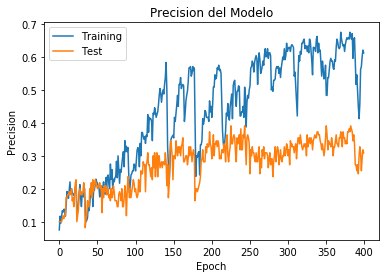

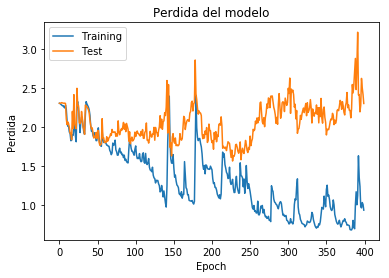

In [51]:
#plot_and_saving(LSTMD5,name='LSTM_Dropout5')

# Propuesta de modelo

In [37]:
LSTM2L2D400_4=LSTM_with_2layers_2D('LSTM400_4',dropout=0.4,n_units=128,n_epochs=400)

Train on 240 samples, validate on 110 samples
Epoch 1/400
240/240 [==============================] - 19s 81ms/step - loss: 2.3036 - acc: 0.0708 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 2/400
240/240 [==============================] - 18s 77ms/step - loss: 2.2970 - acc: 0.1000 - val_loss: 2.3027 - val_acc: 0.0909
Epoch 3/400
240/240 [==============================] - 20s 82ms/step - loss: 2.2838 - acc: 0.0792 - val_loss: 2.3032 - val_acc: 0.1000
Epoch 4/400
240/240 [==============================] - 18s 75ms/step - loss: 2.2800 - acc: 0.1167 - val_loss: 2.3293 - val_acc: 0.0818
Epoch 5/400
240/240 [==============================] - 20s 84ms/step - loss: 2.2851 - acc: 0.1083 - val_loss: 2.3053 - val_acc: 0.0909
Epoch 6/400
240/240 [==============================] - 19s 81ms/step - loss: 2.2833 - acc: 0.1042 - val_loss: 2.3038 - val_acc: 0.0909
Epoch 7/400
240/240 [==============================] - 22s 92ms/step - loss: 2.2797 - acc: 0.1125 - val_loss: 2.3064 - val_acc: 0.1000
Epoch 8/4

Epoch 61/400
240/240 [==============================] - 16s 65ms/step - loss: 2.1801 - acc: 0.1583 - val_loss: 2.3298 - val_acc: 0.1091
Epoch 62/400
240/240 [==============================] - 16s 67ms/step - loss: 2.1370 - acc: 0.1833 - val_loss: 2.4067 - val_acc: 0.1636
Epoch 63/400
240/240 [==============================] - 16s 65ms/step - loss: 2.1428 - acc: 0.1958 - val_loss: 2.3583 - val_acc: 0.1273
Epoch 64/400
240/240 [==============================] - 15s 61ms/step - loss: 2.1265 - acc: 0.1833 - val_loss: 2.3533 - val_acc: 0.1727
Epoch 65/400
240/240 [==============================] - 16s 67ms/step - loss: 2.1438 - acc: 0.2250 - val_loss: 2.3892 - val_acc: 0.1364
Epoch 66/400
240/240 [==============================] - 16s 66ms/step - loss: 2.2536 - acc: 0.1750 - val_loss: 2.3120 - val_acc: 0.1091
Epoch 67/400
240/240 [==============================] - 16s 65ms/step - loss: 2.1870 - acc: 0.1458 - val_loss: 2.3090 - val_acc: 0.1636
Epoch 68/400
240/240 [==========================

240/240 [==============================] - 16s 65ms/step - loss: 1.9421 - acc: 0.2292 - val_loss: 2.1789 - val_acc: 0.2000
Epoch 122/400
240/240 [==============================] - 16s 65ms/step - loss: 1.8919 - acc: 0.2875 - val_loss: 2.1523 - val_acc: 0.2182
Epoch 123/400
240/240 [==============================] - 16s 65ms/step - loss: 1.8330 - acc: 0.2583 - val_loss: 2.1621 - val_acc: 0.2182
Epoch 124/400
240/240 [==============================] - 16s 66ms/step - loss: 1.8418 - acc: 0.3125 - val_loss: 2.1789 - val_acc: 0.2364
Epoch 125/400
240/240 [==============================] - 16s 66ms/step - loss: 1.8554 - acc: 0.2750 - val_loss: 2.1242 - val_acc: 0.2273
Epoch 126/400
240/240 [==============================] - 16s 66ms/step - loss: 1.8296 - acc: 0.3125 - val_loss: 2.2297 - val_acc: 0.2000
Epoch 127/400
240/240 [==============================] - 16s 65ms/step - loss: 1.9083 - acc: 0.2708 - val_loss: 2.2881 - val_acc: 0.2000
Epoch 128/400
240/240 [==============================] 

Epoch 181/400
240/240 [==============================] - 16s 66ms/step - loss: 1.4031 - acc: 0.4625 - val_loss: 2.3501 - val_acc: 0.2545
Epoch 182/400
240/240 [==============================] - 16s 65ms/step - loss: 1.3993 - acc: 0.4583 - val_loss: 2.2617 - val_acc: 0.2455
Epoch 183/400
240/240 [==============================] - 16s 66ms/step - loss: 1.4202 - acc: 0.4667 - val_loss: 2.2849 - val_acc: 0.2727
Epoch 184/400
240/240 [==============================] - 15s 61ms/step - loss: 1.3434 - acc: 0.5083 - val_loss: 2.1981 - val_acc: 0.2636
Epoch 185/400
240/240 [==============================] - 16s 65ms/step - loss: 1.4586 - acc: 0.4625 - val_loss: 2.2531 - val_acc: 0.2818
Epoch 186/400
240/240 [==============================] - 16s 66ms/step - loss: 1.4019 - acc: 0.4625 - val_loss: 2.1800 - val_acc: 0.2909
Epoch 187/400
240/240 [==============================] - 16s 66ms/step - loss: 1.4055 - acc: 0.4708 - val_loss: 2.1879 - val_acc: 0.2545
Epoch 188/400
240/240 [==================

Epoch 241/400
240/240 [==============================] - 16s 65ms/step - loss: 1.3677 - acc: 0.5125 - val_loss: 1.9346 - val_acc: 0.3545
Epoch 242/400
240/240 [==============================] - 15s 64ms/step - loss: 1.3080 - acc: 0.5250 - val_loss: 1.8660 - val_acc: 0.4273
Epoch 243/400
240/240 [==============================] - 16s 65ms/step - loss: 1.3411 - acc: 0.5500 - val_loss: 2.0162 - val_acc: 0.3545
Epoch 244/400
240/240 [==============================] - 16s 65ms/step - loss: 1.8382 - acc: 0.3917 - val_loss: 2.1554 - val_acc: 0.2000
Epoch 245/400
240/240 [==============================] - 15s 64ms/step - loss: 1.9280 - acc: 0.2958 - val_loss: 2.0196 - val_acc: 0.2364
Epoch 246/400
240/240 [==============================] - 16s 65ms/step - loss: 1.8790 - acc: 0.2750 - val_loss: 2.0574 - val_acc: 0.2727
Epoch 247/400
240/240 [==============================] - 16s 65ms/step - loss: 1.7467 - acc: 0.3500 - val_loss: 1.9049 - val_acc: 0.2909
Epoch 248/400
240/240 [==================

Epoch 301/400
240/240 [==============================] - 16s 65ms/step - loss: 0.6023 - acc: 0.7875 - val_loss: 1.5575 - val_acc: 0.5364
Epoch 302/400
240/240 [==============================] - 16s 66ms/step - loss: 0.6624 - acc: 0.7500 - val_loss: 1.5190 - val_acc: 0.5364
Epoch 303/400
240/240 [==============================] - 16s 65ms/step - loss: 0.6197 - acc: 0.7333 - val_loss: 1.7108 - val_acc: 0.5273
Epoch 304/400
240/240 [==============================] - 16s 66ms/step - loss: 0.8849 - acc: 0.6750 - val_loss: 1.4464 - val_acc: 0.6000
Epoch 305/400
240/240 [==============================] - 16s 65ms/step - loss: 0.7105 - acc: 0.7417 - val_loss: 1.5763 - val_acc: 0.5636
Epoch 306/400
240/240 [==============================] - 16s 66ms/step - loss: 0.8013 - acc: 0.7042 - val_loss: 1.6366 - val_acc: 0.5273
Epoch 307/400
240/240 [==============================] - 16s 65ms/step - loss: 0.7120 - acc: 0.7417 - val_loss: 1.5436 - val_acc: 0.5000
Epoch 308/400
240/240 [==================

Epoch 361/400
240/240 [==============================] - 16s 65ms/step - loss: 1.2438 - acc: 0.5458 - val_loss: 1.5873 - val_acc: 0.3455
Epoch 362/400
240/240 [==============================] - 16s 65ms/step - loss: 1.0862 - acc: 0.5833 - val_loss: 1.5148 - val_acc: 0.4727
Epoch 363/400
240/240 [==============================] - 16s 66ms/step - loss: 0.9849 - acc: 0.6125 - val_loss: 1.4106 - val_acc: 0.4455
Epoch 364/400
240/240 [==============================] - 16s 65ms/step - loss: 0.9138 - acc: 0.6708 - val_loss: 1.4761 - val_acc: 0.4727
Epoch 365/400
240/240 [==============================] - 16s 66ms/step - loss: 0.8769 - acc: 0.6542 - val_loss: 1.5949 - val_acc: 0.4364
Epoch 366/400
240/240 [==============================] - 16s 65ms/step - loss: 1.0244 - acc: 0.6250 - val_loss: 1.4490 - val_acc: 0.4818
Epoch 367/400
240/240 [==============================] - 16s 66ms/step - loss: 0.8187 - acc: 0.6500 - val_loss: 1.4323 - val_acc: 0.4818
Epoch 368/400
240/240 [==================

In [38]:
LSTM2L2D600_4=LSTM_with_2layers_2D('LSTM600_4',dropout=0.4,n_units=128,n_epochs=600)

Train on 240 samples, validate on 110 samples
Epoch 1/600
240/240 [==============================] - 19s 79ms/step - loss: 2.3059 - acc: 0.0792 - val_loss: 2.3026 - val_acc: 0.1091
Epoch 2/600
240/240 [==============================] - 16s 67ms/step - loss: 2.3003 - acc: 0.1208 - val_loss: 2.3036 - val_acc: 0.1000
Epoch 3/600
240/240 [==============================] - 16s 66ms/step - loss: 2.2849 - acc: 0.1083 - val_loss: 2.3270 - val_acc: 0.1091
Epoch 4/600
240/240 [==============================] - 16s 67ms/step - loss: 2.2983 - acc: 0.0958 - val_loss: 2.3037 - val_acc: 0.1000
Epoch 5/600
240/240 [==============================] - 16s 67ms/step - loss: 2.2936 - acc: 0.1042 - val_loss: 2.3026 - val_acc: 0.1182
Epoch 6/600
240/240 [==============================] - 16s 67ms/step - loss: 2.2843 - acc: 0.1042 - val_loss: 2.3045 - val_acc: 0.1000
Epoch 7/600
240/240 [==============================] - 16s 67ms/step - loss: 2.2783 - acc: 0.1458 - val_loss: 2.3085 - val_acc: 0.1000
Epoch 8/6

Epoch 61/600
240/240 [==============================] - 16s 67ms/step - loss: 1.4666 - acc: 0.4292 - val_loss: 1.5399 - val_acc: 0.3636
Epoch 62/600
240/240 [==============================] - 16s 67ms/step - loss: 1.3200 - acc: 0.4000 - val_loss: 1.5674 - val_acc: 0.3364
Epoch 63/600
240/240 [==============================] - 16s 67ms/step - loss: 1.3256 - acc: 0.3958 - val_loss: 1.5067 - val_acc: 0.3727
Epoch 64/600
240/240 [==============================] - 16s 67ms/step - loss: 1.3609 - acc: 0.3958 - val_loss: 1.6100 - val_acc: 0.3545
Epoch 65/600
240/240 [==============================] - 16s 67ms/step - loss: 1.3675 - acc: 0.4333 - val_loss: 1.4375 - val_acc: 0.4182
Epoch 66/600
240/240 [==============================] - 16s 66ms/step - loss: 1.2932 - acc: 0.4417 - val_loss: 1.5866 - val_acc: 0.3455
Epoch 67/600
240/240 [==============================] - 16s 67ms/step - loss: 1.3203 - acc: 0.3792 - val_loss: 1.6400 - val_acc: 0.3636
Epoch 68/600
240/240 [==========================

240/240 [==============================] - 16s 67ms/step - loss: 1.1506 - acc: 0.4542 - val_loss: 1.3154 - val_acc: 0.4182
Epoch 122/600
240/240 [==============================] - 16s 67ms/step - loss: 1.3074 - acc: 0.3958 - val_loss: 2.0997 - val_acc: 0.3818
Epoch 123/600
240/240 [==============================] - 16s 67ms/step - loss: 1.5270 - acc: 0.3792 - val_loss: 1.3236 - val_acc: 0.4727
Epoch 124/600
240/240 [==============================] - 16s 66ms/step - loss: 1.2192 - acc: 0.4542 - val_loss: 1.3026 - val_acc: 0.4455
Epoch 125/600
240/240 [==============================] - 15s 64ms/step - loss: 1.1241 - acc: 0.4833 - val_loss: 1.3025 - val_acc: 0.4727
Epoch 126/600
240/240 [==============================] - 16s 67ms/step - loss: 1.1500 - acc: 0.5125 - val_loss: 1.3358 - val_acc: 0.4727
Epoch 127/600
240/240 [==============================] - 16s 67ms/step - loss: 1.1214 - acc: 0.5125 - val_loss: 1.3495 - val_acc: 0.4545
Epoch 128/600
240/240 [==============================] 

Epoch 181/600
240/240 [==============================] - 16s 66ms/step - loss: 1.3179 - acc: 0.4417 - val_loss: 1.4854 - val_acc: 0.4364
Epoch 182/600
240/240 [==============================] - 15s 64ms/step - loss: 1.2507 - acc: 0.4792 - val_loss: 1.5842 - val_acc: 0.3909
Epoch 183/600
240/240 [==============================] - 16s 66ms/step - loss: 1.1611 - acc: 0.5000 - val_loss: 1.4323 - val_acc: 0.4455
Epoch 184/600
240/240 [==============================] - 16s 66ms/step - loss: 1.1424 - acc: 0.5083 - val_loss: 1.4932 - val_acc: 0.3636
Epoch 185/600
240/240 [==============================] - 16s 66ms/step - loss: 1.0522 - acc: 0.5042 - val_loss: 1.4283 - val_acc: 0.4364
Epoch 186/600
240/240 [==============================] - 16s 66ms/step - loss: 1.0213 - acc: 0.5708 - val_loss: 1.4310 - val_acc: 0.3909
Epoch 187/600
240/240 [==============================] - 16s 66ms/step - loss: 0.9848 - acc: 0.5625 - val_loss: 1.3535 - val_acc: 0.4636
Epoch 188/600
240/240 [==================

Epoch 241/600
240/240 [==============================] - 16s 67ms/step - loss: 0.6352 - acc: 0.7500 - val_loss: 1.2549 - val_acc: 0.6182
Epoch 242/600
240/240 [==============================] - 16s 67ms/step - loss: 0.6537 - acc: 0.7458 - val_loss: 1.4271 - val_acc: 0.6091
Epoch 243/600
240/240 [==============================] - 16s 67ms/step - loss: 0.6914 - acc: 0.7208 - val_loss: 1.2708 - val_acc: 0.6091
Epoch 244/600
240/240 [==============================] - 16s 66ms/step - loss: 0.6863 - acc: 0.7208 - val_loss: 1.3794 - val_acc: 0.5636
Epoch 245/600
240/240 [==============================] - 16s 68ms/step - loss: 0.6661 - acc: 0.6958 - val_loss: 1.3732 - val_acc: 0.5636
Epoch 246/600
240/240 [==============================] - 15s 63ms/step - loss: 0.6890 - acc: 0.7417 - val_loss: 1.2690 - val_acc: 0.5364
Epoch 247/600
240/240 [==============================] - 16s 66ms/step - loss: 0.5690 - acc: 0.7500 - val_loss: 1.3758 - val_acc: 0.5636
Epoch 248/600
240/240 [==================

Epoch 301/600
240/240 [==============================] - 16s 67ms/step - loss: 0.6563 - acc: 0.7458 - val_loss: 1.1299 - val_acc: 0.6727
Epoch 302/600
240/240 [==============================] - 16s 66ms/step - loss: 0.5929 - acc: 0.7917 - val_loss: 1.3065 - val_acc: 0.6182
Epoch 303/600
240/240 [==============================] - 16s 67ms/step - loss: 0.6340 - acc: 0.7833 - val_loss: 1.3060 - val_acc: 0.6000
Epoch 304/600
240/240 [==============================] - 16s 68ms/step - loss: 0.5109 - acc: 0.8167 - val_loss: 1.2516 - val_acc: 0.6182
Epoch 305/600
240/240 [==============================] - 16s 66ms/step - loss: 0.6940 - acc: 0.7333 - val_loss: 1.5454 - val_acc: 0.5727
Epoch 306/600
240/240 [==============================] - 16s 68ms/step - loss: 0.7075 - acc: 0.7667 - val_loss: 1.1365 - val_acc: 0.6273
Epoch 307/600
240/240 [==============================] - 16s 67ms/step - loss: 0.6137 - acc: 0.8125 - val_loss: 0.9868 - val_acc: 0.6727
Epoch 308/600
240/240 [==================

Epoch 361/600
240/240 [==============================] - 16s 66ms/step - loss: 0.1595 - acc: 0.9417 - val_loss: 1.3496 - val_acc: 0.6909
Epoch 362/600
240/240 [==============================] - 16s 66ms/step - loss: 0.1841 - acc: 0.9500 - val_loss: 1.3037 - val_acc: 0.7182
Epoch 363/600
240/240 [==============================] - 16s 66ms/step - loss: 0.1003 - acc: 0.9792 - val_loss: 1.3695 - val_acc: 0.7182
Epoch 364/600
240/240 [==============================] - 16s 67ms/step - loss: 0.1052 - acc: 0.9667 - val_loss: 1.4358 - val_acc: 0.6909
Epoch 365/600
240/240 [==============================] - 16s 67ms/step - loss: 0.3174 - acc: 0.9125 - val_loss: 1.3826 - val_acc: 0.6727
Epoch 366/600
240/240 [==============================] - 16s 67ms/step - loss: 0.3085 - acc: 0.9167 - val_loss: 1.3923 - val_acc: 0.6909
Epoch 367/600
240/240 [==============================] - 16s 66ms/step - loss: 0.3624 - acc: 0.9000 - val_loss: 1.3210 - val_acc: 0.6909
Epoch 368/600
240/240 [==================

Epoch 421/600
240/240 [==============================] - 16s 67ms/step - loss: 0.1687 - acc: 0.9417 - val_loss: 1.0380 - val_acc: 0.7727
Epoch 422/600
240/240 [==============================] - 16s 68ms/step - loss: 0.1639 - acc: 0.9500 - val_loss: 0.9590 - val_acc: 0.7727
Epoch 423/600
240/240 [==============================] - 16s 67ms/step - loss: 0.2003 - acc: 0.9500 - val_loss: 0.9215 - val_acc: 0.8000
Epoch 424/600
240/240 [==============================] - 16s 67ms/step - loss: 0.1384 - acc: 0.9625 - val_loss: 0.8746 - val_acc: 0.8000
Epoch 425/600
240/240 [==============================] - 16s 67ms/step - loss: 0.1349 - acc: 0.9625 - val_loss: 0.9286 - val_acc: 0.8000
Epoch 426/600
240/240 [==============================] - 16s 66ms/step - loss: 0.4139 - acc: 0.8833 - val_loss: 1.3037 - val_acc: 0.6818
Epoch 427/600
240/240 [==============================] - 16s 67ms/step - loss: 0.5833 - acc: 0.8167 - val_loss: 1.2277 - val_acc: 0.7091
Epoch 428/600
240/240 [==================

Epoch 481/600
240/240 [==============================] - 16s 66ms/step - loss: 0.5326 - acc: 0.8250 - val_loss: 1.1271 - val_acc: 0.7091
Epoch 482/600
240/240 [==============================] - 16s 66ms/step - loss: 0.4284 - acc: 0.8667 - val_loss: 1.1565 - val_acc: 0.7273
Epoch 483/600
240/240 [==============================] - 16s 66ms/step - loss: 0.4050 - acc: 0.8625 - val_loss: 1.0806 - val_acc: 0.7364
Epoch 484/600
240/240 [==============================] - 16s 67ms/step - loss: 0.4027 - acc: 0.8583 - val_loss: 1.2933 - val_acc: 0.7000
Epoch 485/600
240/240 [==============================] - 16s 67ms/step - loss: 0.4830 - acc: 0.8458 - val_loss: 1.6568 - val_acc: 0.6545
Epoch 486/600
240/240 [==============================] - 16s 67ms/step - loss: 0.5861 - acc: 0.8125 - val_loss: 1.2662 - val_acc: 0.7364
Epoch 487/600
240/240 [==============================] - 16s 67ms/step - loss: 0.4552 - acc: 0.8708 - val_loss: 1.2034 - val_acc: 0.7000
Epoch 488/600
240/240 [==================

Epoch 541/600
240/240 [==============================] - 16s 67ms/step - loss: 0.4225 - acc: 0.8542 - val_loss: 1.1821 - val_acc: 0.6818
Epoch 542/600
240/240 [==============================] - 16s 67ms/step - loss: 0.2995 - acc: 0.8875 - val_loss: 1.1668 - val_acc: 0.7273
Epoch 543/600
240/240 [==============================] - 16s 66ms/step - loss: 0.2716 - acc: 0.9167 - val_loss: 1.1370 - val_acc: 0.7000
Epoch 544/600
240/240 [==============================] - 16s 67ms/step - loss: 0.2594 - acc: 0.9083 - val_loss: 1.3281 - val_acc: 0.6636
Epoch 545/600
240/240 [==============================] - 16s 67ms/step - loss: 0.3427 - acc: 0.8792 - val_loss: 1.3409 - val_acc: 0.6455
Epoch 546/600
240/240 [==============================] - 16s 67ms/step - loss: 0.3856 - acc: 0.8542 - val_loss: 1.2580 - val_acc: 0.6727
Epoch 547/600
240/240 [==============================] - 16s 67ms/step - loss: 0.2635 - acc: 0.9083 - val_loss: 1.2691 - val_acc: 0.6727
Epoch 548/600
240/240 [==================

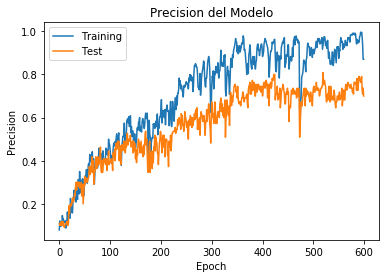

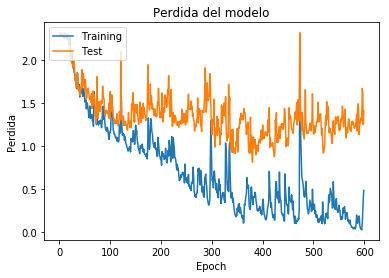

In [41]:
plot_and_saving(LSTM2L2D600_4,'LSTM600_4')

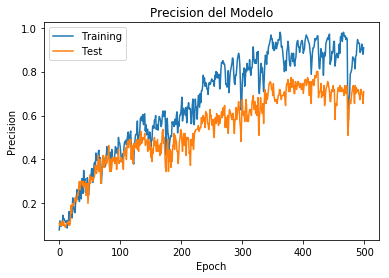

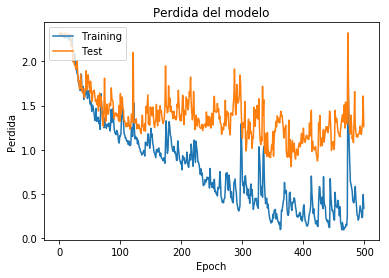

In [45]:
plt.plot(LSTM2L2D600_4.history['acc'][0:500])
plt.plot(LSTM2L2D600_4.history['val_acc'][0:500])
plt.title('Precision del Modelo')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='upper left')
plt.savefig('prec500')
plt.show()
# Plot training & validation loss values
plt.plot(LSTM2L2D600_4.history['loss'][0:500])
plt.plot(LSTM2L2D600_4.history['val_loss'][0:500])
plt.title('Perdida del modelo')
plt.ylabel('Perdida')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='upper left')
plt.savefig('cost500')
plt.show()

In [31]:
LSTM2L2D500_4_256=LSTM_with_2layers_2D('LSTM500_4_256',dropout=0.4,n_units=256,n_epochs=500)

Train on 240 samples, validate on 110 samples
Epoch 1/500
240/240 [==============================] - 20s 85ms/step - loss: 2.3064 - acc: 0.0917 - val_loss: 2.3031 - val_acc: 0.1000
Epoch 2/500
240/240 [==============================] - 19s 80ms/step - loss: 2.2945 - acc: 0.0958 - val_loss: 2.3045 - val_acc: 0.1000
Epoch 3/500
240/240 [==============================] - 20s 82ms/step - loss: 2.2996 - acc: 0.1000 - val_loss: 2.3050 - val_acc: 0.0909
Epoch 4/500
240/240 [==============================] - 21s 88ms/step - loss: 2.2940 - acc: 0.1042 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 5/500
240/240 [==============================] - 23s 97ms/step - loss: 2.2891 - acc: 0.0875 - val_loss: 2.3035 - val_acc: 0.1182
Epoch 6/500
240/240 [==============================] - 30s 124ms/step - loss: 2.2809 - acc: 0.1083 - val_loss: 2.3080 - val_acc: 0.0909
Epoch 7/500
240/240 [==============================] - 19s 79ms/step - loss: 2.2856 - acc: 0.1042 - val_loss: 2.3019 - val_acc: 0.1091
Epoch 8/

Epoch 61/500
240/240 [==============================] - 17s 71ms/step - loss: 2.2172 - acc: 0.1125 - val_loss: 2.2883 - val_acc: 0.1182
Epoch 62/500
240/240 [==============================] - 17s 71ms/step - loss: 2.1942 - acc: 0.1500 - val_loss: 2.3175 - val_acc: 0.1636
Epoch 63/500
240/240 [==============================] - 17s 71ms/step - loss: 2.2924 - acc: 0.1375 - val_loss: 2.3214 - val_acc: 0.1545
Epoch 64/500
240/240 [==============================] - 17s 70ms/step - loss: 2.2225 - acc: 0.1542 - val_loss: 2.3357 - val_acc: 0.0818
Epoch 65/500
240/240 [==============================] - 17s 72ms/step - loss: 2.2309 - acc: 0.1375 - val_loss: 2.3075 - val_acc: 0.1000
Epoch 66/500
240/240 [==============================] - 18s 77ms/step - loss: 2.2444 - acc: 0.1417 - val_loss: 2.2895 - val_acc: 0.0818
Epoch 67/500
240/240 [==============================] - 19s 79ms/step - loss: 2.1960 - acc: 0.1792 - val_loss: 2.3318 - val_acc: 0.1000
Epoch 68/500
240/240 [==========================

240/240 [==============================] - 17s 72ms/step - loss: 2.2881 - acc: 0.0917 - val_loss: 2.2988 - val_acc: 0.1091
Epoch 122/500
240/240 [==============================] - 18s 73ms/step - loss: 2.2602 - acc: 0.1167 - val_loss: 2.3001 - val_acc: 0.1091
Epoch 123/500
240/240 [==============================] - 17s 73ms/step - loss: 2.2453 - acc: 0.1333 - val_loss: 2.3297 - val_acc: 0.1091
Epoch 124/500
240/240 [==============================] - 18s 73ms/step - loss: 2.2320 - acc: 0.1333 - val_loss: 2.3155 - val_acc: 0.1000
Epoch 125/500
240/240 [==============================] - 17s 71ms/step - loss: 2.2329 - acc: 0.1292 - val_loss: 2.3092 - val_acc: 0.1091
Epoch 126/500
240/240 [==============================] - 17s 70ms/step - loss: 2.2077 - acc: 0.1458 - val_loss: 2.3599 - val_acc: 0.0909
Epoch 127/500
240/240 [==============================] - 17s 71ms/step - loss: 2.2249 - acc: 0.1417 - val_loss: 2.3250 - val_acc: 0.1000
Epoch 128/500
240/240 [==============================] 

Epoch 181/500
240/240 [==============================] - 19s 77ms/step - loss: 2.0426 - acc: 0.2375 - val_loss: 2.2080 - val_acc: 0.2091
Epoch 182/500
240/240 [==============================] - 19s 78ms/step - loss: 2.0937 - acc: 0.1833 - val_loss: 2.2789 - val_acc: 0.1182
Epoch 183/500
240/240 [==============================] - 18s 74ms/step - loss: 2.0839 - acc: 0.2250 - val_loss: 2.2459 - val_acc: 0.1182
Epoch 184/500
240/240 [==============================] - 19s 79ms/step - loss: 2.0111 - acc: 0.2500 - val_loss: 2.2270 - val_acc: 0.1727
Epoch 185/500
240/240 [==============================] - 19s 80ms/step - loss: 1.9424 - acc: 0.2542 - val_loss: 2.2253 - val_acc: 0.1455
Epoch 186/500
240/240 [==============================] - 20s 82ms/step - loss: 2.0426 - acc: 0.2042 - val_loss: 2.1625 - val_acc: 0.1455
Epoch 187/500
240/240 [==============================] - 20s 84ms/step - loss: 2.1124 - acc: 0.1917 - val_loss: 2.4509 - val_acc: 0.0636
Epoch 188/500
240/240 [==================

Epoch 241/500
240/240 [==============================] - 17s 72ms/step - loss: 1.8779 - acc: 0.2917 - val_loss: 2.2646 - val_acc: 0.2273
Epoch 242/500
240/240 [==============================] - 17s 72ms/step - loss: 1.8551 - acc: 0.2792 - val_loss: 2.3358 - val_acc: 0.2182
Epoch 243/500
240/240 [==============================] - 17s 72ms/step - loss: 1.8905 - acc: 0.2875 - val_loss: 2.3320 - val_acc: 0.2000
Epoch 244/500
240/240 [==============================] - 22s 91ms/step - loss: 1.8591 - acc: 0.2750 - val_loss: 2.3076 - val_acc: 0.2091
Epoch 245/500
240/240 [==============================] - 23s 96ms/step - loss: 1.9099 - acc: 0.2708 - val_loss: 2.3028 - val_acc: 0.1909
Epoch 246/500
240/240 [==============================] - 27s 112ms/step - loss: 1.8766 - acc: 0.2667 - val_loss: 2.3527 - val_acc: 0.2182
Epoch 247/500
240/240 [==============================] - 24s 101ms/step - loss: 1.9487 - acc: 0.2292 - val_loss: 2.3414 - val_acc: 0.2182
Epoch 248/500
240/240 [================

Epoch 301/500
240/240 [==============================] - 24s 100ms/step - loss: 1.7213 - acc: 0.3500 - val_loss: 2.2768 - val_acc: 0.2091
Epoch 302/500
240/240 [==============================] - 23s 97ms/step - loss: 1.7913 - acc: 0.3208 - val_loss: 2.5013 - val_acc: 0.1545
Epoch 303/500
240/240 [==============================] - 18s 74ms/step - loss: 1.7935 - acc: 0.3000 - val_loss: 2.4209 - val_acc: 0.2000
Epoch 304/500
240/240 [==============================] - 21s 88ms/step - loss: 1.7823 - acc: 0.3292 - val_loss: 2.4340 - val_acc: 0.1545
Epoch 305/500
240/240 [==============================] - 27s 111ms/step - loss: 1.7438 - acc: 0.3458 - val_loss: 2.4117 - val_acc: 0.1727
Epoch 306/500
240/240 [==============================] - 20s 82ms/step - loss: 1.5749 - acc: 0.4000 - val_loss: 2.3205 - val_acc: 0.1909
Epoch 307/500
240/240 [==============================] - 18s 73ms/step - loss: 1.6360 - acc: 0.3958 - val_loss: 2.3801 - val_acc: 0.2091
Epoch 308/500
240/240 [================

Epoch 361/500
240/240 [==============================] - 17s 72ms/step - loss: 1.4547 - acc: 0.4458 - val_loss: 2.4232 - val_acc: 0.2364
Epoch 362/500
240/240 [==============================] - 17s 72ms/step - loss: 1.3580 - acc: 0.4417 - val_loss: 2.2874 - val_acc: 0.2818
Epoch 363/500
240/240 [==============================] - 17s 72ms/step - loss: 1.2572 - acc: 0.5125 - val_loss: 2.2864 - val_acc: 0.2727
Epoch 364/500
240/240 [==============================] - 17s 72ms/step - loss: 1.1844 - acc: 0.5625 - val_loss: 2.3373 - val_acc: 0.2636
Epoch 365/500
240/240 [==============================] - 21s 86ms/step - loss: 1.0954 - acc: 0.5833 - val_loss: 2.3255 - val_acc: 0.2909
Epoch 366/500
240/240 [==============================] - 19s 80ms/step - loss: 1.1137 - acc: 0.5958 - val_loss: 2.3286 - val_acc: 0.2818
Epoch 367/500
240/240 [==============================] - 17s 72ms/step - loss: 1.1395 - acc: 0.5292 - val_loss: 2.4149 - val_acc: 0.2455
Epoch 368/500
240/240 [==================

Epoch 421/500
240/240 [==============================] - 18s 77ms/step - loss: 0.7202 - acc: 0.7125 - val_loss: 2.8915 - val_acc: 0.3182
Epoch 422/500
240/240 [==============================] - 19s 79ms/step - loss: 0.7152 - acc: 0.7208 - val_loss: 2.7574 - val_acc: 0.3000
Epoch 423/500
240/240 [==============================] - 17s 73ms/step - loss: 0.8122 - acc: 0.6958 - val_loss: 2.6024 - val_acc: 0.3636
Epoch 424/500
240/240 [==============================] - 17s 72ms/step - loss: 0.8124 - acc: 0.6875 - val_loss: 2.7039 - val_acc: 0.3545
Epoch 425/500
240/240 [==============================] - 18s 76ms/step - loss: 0.7322 - acc: 0.7125 - val_loss: 2.7391 - val_acc: 0.3364
Epoch 426/500
240/240 [==============================] - 19s 77ms/step - loss: 0.8049 - acc: 0.6750 - val_loss: 2.8021 - val_acc: 0.2545
Epoch 427/500
240/240 [==============================] - 19s 79ms/step - loss: 0.7491 - acc: 0.7208 - val_loss: 2.9113 - val_acc: 0.2818
Epoch 428/500
240/240 [==================

Epoch 481/500
240/240 [==============================] - 19s 81ms/step - loss: 0.4533 - acc: 0.8083 - val_loss: 3.2499 - val_acc: 0.2818
Epoch 482/500
240/240 [==============================] - 19s 78ms/step - loss: 0.4140 - acc: 0.8375 - val_loss: 3.3699 - val_acc: 0.3000
Epoch 483/500
240/240 [==============================] - 21s 86ms/step - loss: 0.3712 - acc: 0.8708 - val_loss: 3.5304 - val_acc: 0.2909
Epoch 484/500
240/240 [==============================] - 19s 77ms/step - loss: 0.3256 - acc: 0.8917 - val_loss: 3.5367 - val_acc: 0.3000
Epoch 485/500
240/240 [==============================] - 21s 87ms/step - loss: 0.2993 - acc: 0.8792 - val_loss: 3.7097 - val_acc: 0.3182
Epoch 486/500
240/240 [==============================] - 20s 84ms/step - loss: 0.2931 - acc: 0.8833 - val_loss: 3.7878 - val_acc: 0.2727
Epoch 487/500
240/240 [==============================] - 20s 85ms/step - loss: 0.3991 - acc: 0.8708 - val_loss: 3.7093 - val_acc: 0.3000
Epoch 488/500
240/240 [==================

In [ ]:
LSTM2L2D600_5=LSTM_with_2layers_2D('LSTM600_5',dropout=0.5,n_units=64,n_epochs=600)

In [ ]:
LSTM2L2D400_6=LSTM_with_2layers_2D('LSTM400_6',dropout=0.6,n_units=64,n_epochs=400)

In [ ]:
LSTM2L2D600_6=LSTM_with_2layers_2D('LSTM600_6',dropout=0.6,n_units=64,n_epochs=600)

In [ ]:
LSTM2L2D400_7=LSTM_with_2layers_2D('LSTM400_7',dropout=0.7,n_units=64,n_epochs=400)

In [ ]:
LSTM2L2D600_7=LSTM_with_2layers_2D('LSTM600_7',dropout=0.7,n_units=64,n_epochs=600)

In [ ]:
LSTM2L2D400_8=LSTM_with_2layers_2D('LSTM400_8',dropout=0.8,n_units=64,n_epochs=400)

In [ ]:
LSTM2L2D600_8=LSTM_with_2layers_2D('LSTM600_8',dropout=0.8,n_units=64,n_epochs=600)

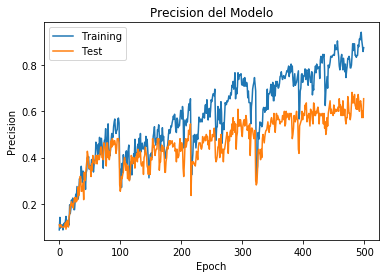

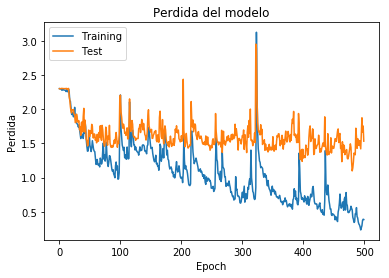

In [59]:
#plot_and_saving(LSTM2_1,'LSTM_2Layer2D6006')

In [55]:
LSTM2_2=LSTM_with_2layers_2D('LSTM_2Layer2D5007',dropout=0.7,n_units=64,n_epochs=500)

Train on 240 samples, validate on 110 samples
Epoch 1/500
240/240 [==============================] - 11s 44ms/step - loss: 2.3055 - acc: 0.0875 - val_loss: 2.3029 - val_acc: 0.1000
Epoch 2/500
240/240 [==============================] - 9s 38ms/step - loss: 2.3017 - acc: 0.1000 - val_loss: 2.3032 - val_acc: 0.0909
Epoch 3/500
240/240 [==============================] - 10s 41ms/step - loss: 2.3017 - acc: 0.0875 - val_loss: 2.3033 - val_acc: 0.1182
Epoch 4/500
240/240 [==============================] - 10s 42ms/step - loss: 2.2963 - acc: 0.1125 - val_loss: 2.3065 - val_acc: 0.0909
Epoch 5/500
240/240 [==============================] - 9s 36ms/step - loss: 2.2966 - acc: 0.0750 - val_loss: 2.3066 - val_acc: 0.1091
Epoch 6/500
240/240 [==============================] - 12s 49ms/step - loss: 2.2872 - acc: 0.1167 - val_loss: 2.3067 - val_acc: 0.1000
Epoch 7/500
240/240 [==============================] - 11s 47ms/step - loss: 2.2795 - acc: 0.0917 - val_loss: 2.3063 - val_acc: 0.1182
Epoch 8/500

240/240 [==============================] - 12s 49ms/step - loss: 1.3324 - acc: 0.4042 - val_loss: 1.9375 - val_acc: 0.3182
Epoch 122/500
240/240 [==============================] - 9s 36ms/step - loss: 1.3014 - acc: 0.4417 - val_loss: 1.6676 - val_acc: 0.3273
Epoch 123/500
240/240 [==============================] - 8s 35ms/step - loss: 1.1769 - acc: 0.4792 - val_loss: 1.5494 - val_acc: 0.3818
Epoch 124/500
240/240 [==============================] - 7s 31ms/step - loss: 1.1973 - acc: 0.4792 - val_loss: 1.6402 - val_acc: 0.3182
Epoch 125/500
240/240 [==============================] - 9s 35ms/step - loss: 1.2432 - acc: 0.4125 - val_loss: 1.7062 - val_acc: 0.3455
Epoch 126/500
240/240 [==============================] - 7s 31ms/step - loss: 1.1866 - acc: 0.4250 - val_loss: 1.6489 - val_acc: 0.4000
Epoch 127/500
240/240 [==============================] - 8s 32ms/step - loss: 1.1541 - acc: 0.4292 - val_loss: 1.6099 - val_acc: 0.4182
Epoch 128/500
240/240 [==============================] - 8s 3

240/240 [==============================] - 8s 32ms/step - loss: 0.8619 - acc: 0.5875 - val_loss: 1.4137 - val_acc: 0.4909
Epoch 242/500
240/240 [==============================] - 8s 34ms/step - loss: 0.8737 - acc: 0.6000 - val_loss: 1.5073 - val_acc: 0.4545
Epoch 243/500
240/240 [==============================] - 8s 33ms/step - loss: 1.1514 - acc: 0.5250 - val_loss: 1.7493 - val_acc: 0.4182
Epoch 244/500
240/240 [==============================] - 8s 33ms/step - loss: 1.1573 - acc: 0.5042 - val_loss: 1.4933 - val_acc: 0.4727
Epoch 245/500
240/240 [==============================] - 8s 35ms/step - loss: 1.0695 - acc: 0.5708 - val_loss: 1.4708 - val_acc: 0.4273
Epoch 246/500
240/240 [==============================] - 8s 34ms/step - loss: 1.0488 - acc: 0.4958 - val_loss: 1.4731 - val_acc: 0.4727
Epoch 247/500
240/240 [==============================] - 8s 33ms/step - loss: 1.0548 - acc: 0.5750 - val_loss: 1.3739 - val_acc: 0.4818
Epoch 248/500
240/240 [==============================] - 8s 34

240/240 [==============================] - 8s 35ms/step - loss: 0.8905 - acc: 0.5833 - val_loss: 1.4618 - val_acc: 0.5000
Epoch 362/500
240/240 [==============================] - 9s 38ms/step - loss: 0.8594 - acc: 0.6500 - val_loss: 1.5797 - val_acc: 0.5545
Epoch 363/500
240/240 [==============================] - 8s 35ms/step - loss: 0.8671 - acc: 0.5833 - val_loss: 1.5215 - val_acc: 0.5000
Epoch 364/500
240/240 [==============================] - 8s 33ms/step - loss: 0.8686 - acc: 0.6417 - val_loss: 1.4469 - val_acc: 0.5000
Epoch 365/500
240/240 [==============================] - 8s 33ms/step - loss: 0.8873 - acc: 0.6083 - val_loss: 1.5150 - val_acc: 0.4818
Epoch 366/500
240/240 [==============================] - 8s 32ms/step - loss: 0.8065 - acc: 0.6750 - val_loss: 1.5063 - val_acc: 0.5000
Epoch 367/500
240/240 [==============================] - 8s 31ms/step - loss: 0.8084 - acc: 0.6292 - val_loss: 1.4984 - val_acc: 0.5273
Epoch 368/500
240/240 [==============================] - 8s 34

240/240 [==============================] - 10s 43ms/step - loss: 0.5050 - acc: 0.7458 - val_loss: 1.5948 - val_acc: 0.5909
Epoch 482/500
240/240 [==============================] - 10s 43ms/step - loss: 0.5442 - acc: 0.7458 - val_loss: 1.5593 - val_acc: 0.6182
Epoch 483/500
240/240 [==============================] - 11s 45ms/step - loss: 0.4758 - acc: 0.7542 - val_loss: 1.7096 - val_acc: 0.5636
Epoch 484/500
240/240 [==============================] - 10s 43ms/step - loss: 0.5082 - acc: 0.7292 - val_loss: 1.6115 - val_acc: 0.5636
Epoch 485/500
240/240 [==============================] - 10s 43ms/step - loss: 0.4574 - acc: 0.8042 - val_loss: 1.5923 - val_acc: 0.5636
Epoch 486/500
240/240 [==============================] - 10s 43ms/step - loss: 0.4336 - acc: 0.7625 - val_loss: 1.6521 - val_acc: 0.6273
Epoch 487/500
240/240 [==============================] - 10s 43ms/step - loss: 0.4725 - acc: 0.7500 - val_loss: 1.5673 - val_acc: 0.6182
Epoch 488/500
240/240 [==============================] 

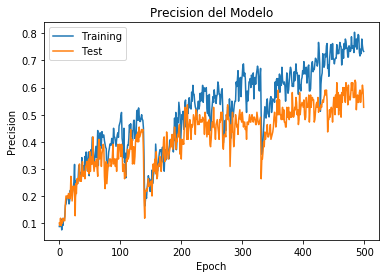

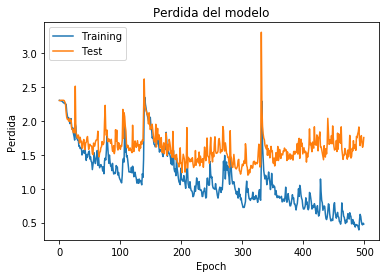

In [61]:
plot_and_saving(LSTM2_2,'LSTM_2Layer2D5007')

# Load Model 

En esta sección se cargará el modelo propuesto para realizar las pruebas

In [44]:
import tensorflow as tf
from keras.utils import plot_model

Using TensorFlow backend.


In [45]:
def load_model(dir):
    m=tf.keras.models.load_model(dir)
    return m